In [ ]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 2
import matplotlib
import matplotlib.pyplot as plt
import celltypist
from celltypist import models

In [ ]:
import anndata as ad
import os

data_folder = '/Users/aziz/Untitled Folder/gaydosik_2019_data/gaydosik_2019_filtered'

# List all .h5ad files in the directory
h5ad_files = [f for f in os.listdir(data_folder) if f.endswith('.h5ad')]

file_to_load = os.path.join(data_folder, 'hc3.h5ad')  # Replace 'hc3.h5ad' with the desired file
adata = ad.read_h5ad(file_to_load)

adata

AnnData object with n_obs × n_vars = 4707 × 22472
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'louvain', 'pheno_louvain', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'louvain', 'neighbors', 'over_clustering', 'pca', 'pheno_jaccard_q', 'predicted_labels_colors', 'rank_genes_groups', 'scrublet',

In [ ]:
# # Check if 'predicted_labels' is present
# if 'predicted_labels' not in adata.obs:
#     print("The 'predicted_labels' column is not present in adata.obs.")
# else:
#     print(adata.obs['predicted_labels'].unique())


In [ ]:
# Plot UMAP
sc.pl.umap(adata, color='predicted_labels', title="UMAP with Predicted Labels", frameon=False)

In [ ]:
import anndata as ad
import os

# Initialize an empty dictionary to hold datasets
datasets = {}

# Iterate over all .h5ad files and load them
for file in h5ad_files:  # Use the previously defined `h5ad_files` list
    file_path = os.path.join(data_folder, file)  # Construct the full path
    datasets[file.replace('.h5ad', '')] = ad.read_h5ad(file_path)  # Store with name excluding '.h5ad'

# Print summary of datasets loaded
for key, data in datasets.items():
    print(f"{key}: {data.shape}")

hc3: (4707, 22472)
mf6: (4657, 22653)
hc2: (2162, 21175)
hc4: (3240, 22167)
mf12: (3571, 21900)
mf2: (4462, 21389)
mf5: (9187, 23354)
hc1: (3756, 21889)
mf8: (8552, 22764)


In [ ]:
import numpy as np

# Get the set of gene names (assuming these are the features) for each dataset
feature_sets = [set(data.var_names) for data in datasets.values()]

# Find the intersection of all feature sets
common_features = set.intersection(*feature_sets)

print(f"Number of common features across all datasets: {len(common_features)}")

Number of common features across all datasets: 17680


In [ ]:
# Filter each dataset to include only common features
filtered_datasets = {}
for key, data in datasets.items():
    filtered_datasets[key] = data[:, list(common_features)]

# Verify that all filtered datasets have the same number of features
for key, data in filtered_datasets.items():
    print(f"{key}: {data.shape}")

hc3: (4707, 17680)
mf6: (4657, 17680)
hc2: (2162, 17680)
hc4: (3240, 17680)
mf12: (3571, 17680)
mf2: (4462, 17680)
mf5: (9187, 17680)
hc1: (3756, 17680)
mf8: (8552, 17680)


In [ ]:
# Create a list of AnnData objects
dataset_list = list(datasets.values())

# # Example: Access first dataset
# print(dataset_list[0].shape)

Combined data shape: (19567, 17680)
Number of samples: 19567
Number of features: 17680
Accuracy: 0.9833929483903935
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1155
         1.0       0.99      0.99      0.99      2759

    accuracy                           0.98      3914
   macro avg       0.98      0.98      0.98      3914
weighted avg       0.98      0.98      0.98      3914



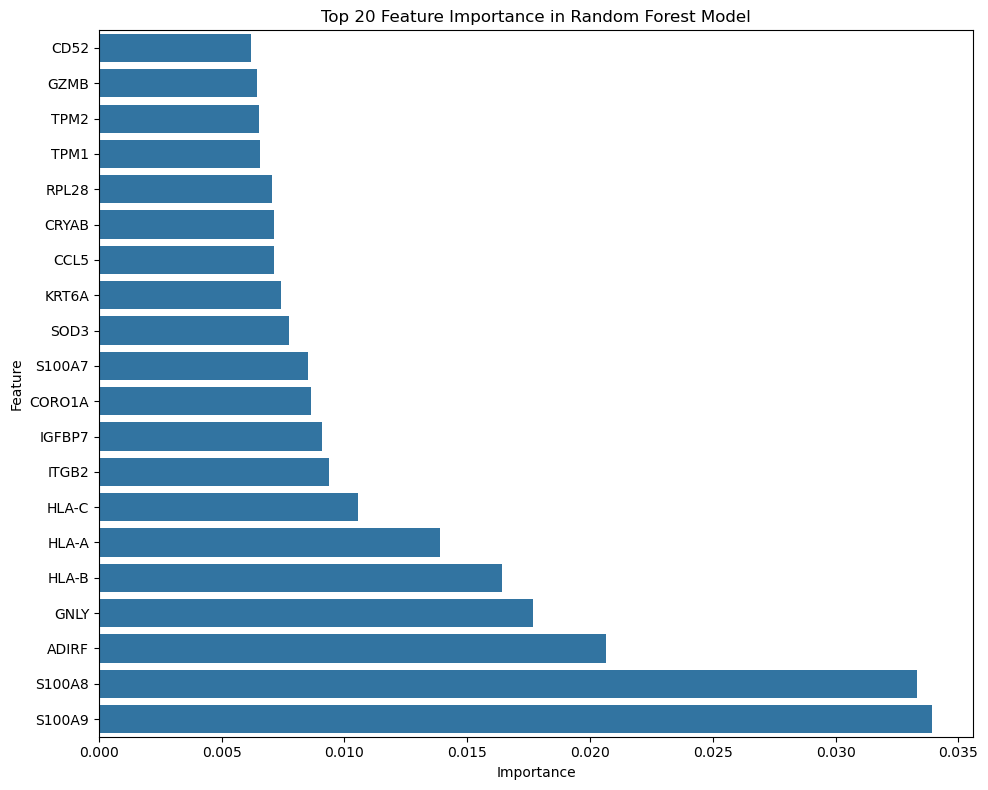

Top 20 potential biomarkers:
CD52: 0.006181715092884074
GZMB: 0.006445447130394455
TPM2: 0.006511038912353948
TPM1: 0.006563122380289775
RPL28: 0.007040984625203461
CRYAB: 0.007134676637277053
CCL5: 0.007142120731106055
KRT6A: 0.007401874174779516
SOD3: 0.007755453871275111
S100A7: 0.008505398379561158
CORO1A: 0.008635228422540482
IGFBP7: 0.0091052195990516
ITGB2: 0.009384688199192474
HLA-C: 0.010537349623066645
HLA-A: 0.01390066206635547
HLA-B: 0.01640205966506463
GNLY: 0.017693990974380288
ADIRF: 0.020637056464998742
S100A8: 0.03330504253296884
S100A9: 0.03390513706602717


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.sparse import vstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Combine HC datasets (using only hc1 and hc2)
hc_data = vstack([filtered_datasets['hc1'].X, filtered_datasets['hc2'].X])
hc_labels = np.zeros(hc_data.shape[0])

# Combine MF datasets (using only mf2 and mf5)
mf_data = vstack([filtered_datasets['mf2'].X, filtered_datasets['mf5'].X])
mf_labels = np.ones(mf_data.shape[0])

# Combine all data
X = vstack([hc_data, mf_data])
y = np.concatenate([hc_labels, mf_labels])

print(f"Combined data shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Identify top features (potential biomarkers)
feature_importance = rf_model.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features
top_feature_names = filtered_datasets['hc1'].var_names[top_features]  # Assuming all datasets have the same feature names

# Create a dataframe for the top features and their importance
top_feature_df = pd.DataFrame({
    'feature': top_feature_names,
    'importance': feature_importance[top_features]
}).sort_values('importance', ascending=True)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_feature_df)
plt.title('Top 20 Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the top 20 potential biomarkers
print("Top 20 potential biomarkers:")
for feature, importance in zip(top_feature_df['feature'], top_feature_df['importance']):
    print(f"{feature}: {importance}")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
print(classification_report(y_test, y_pred_knn))

Combined data shape: (44294, 17680)
Number of samples: 44294
Number of features: 17680
Accuracy: 0.9811491138954735
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      2816
         1.0       0.98      0.99      0.99      6043

    accuracy                           0.98      8859
   macro avg       0.98      0.97      0.98      8859
weighted avg       0.98      0.98      0.98      8859



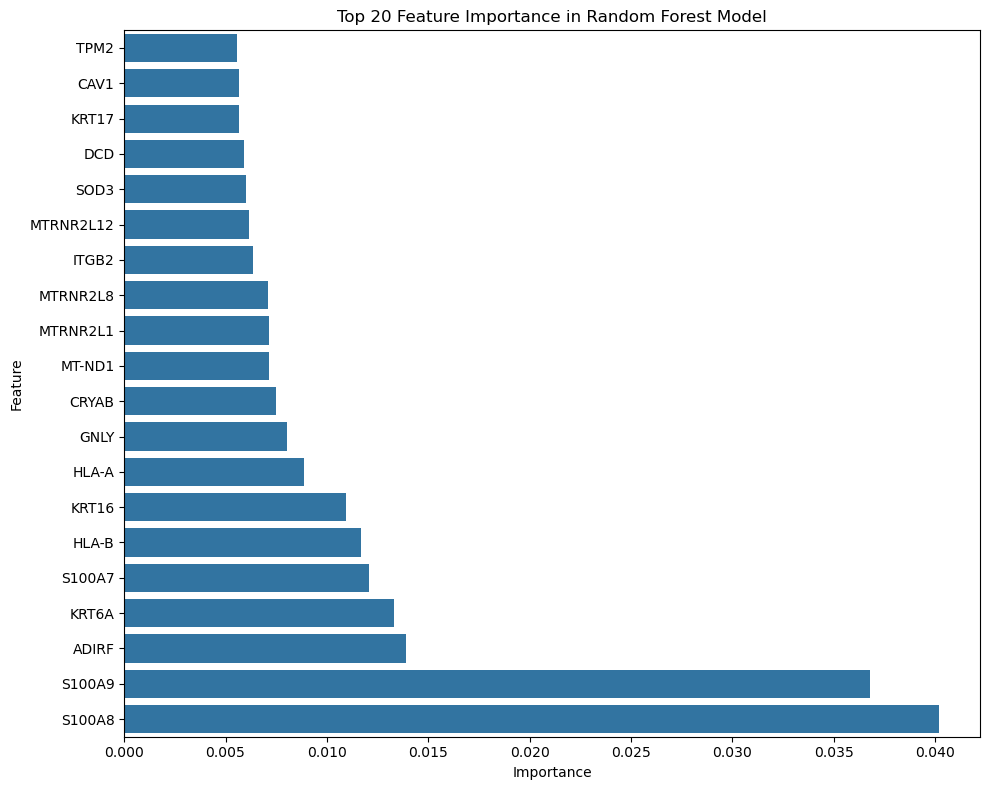

Top 20 potential biomarkers:
TPM2: 0.0055757702965330835
CAV1: 0.005664096841744124
KRT17: 0.005673206747916697
DCD: 0.005888324430654167
SOD3: 0.00601614852582955
MTRNR2L12: 0.006140046995263537
ITGB2: 0.006364082825245261
MTRNR2L8: 0.00711127849655451
MTRNR2L1: 0.007134251041548899
MT-ND1: 0.007141748030017389
CRYAB: 0.0074883708490469745
GNLY: 0.00801676591067762
HLA-A: 0.00885540647647542
KRT16: 0.01094869047902026
HLA-B: 0.011704925612169707
S100A7: 0.01206753714424071
KRT6A: 0.013307397568232671
ADIRF: 0.013921105801847961
S100A9: 0.03679010045713759
S100A8: 0.04020512441256975


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.sparse import vstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Combine all HC datasets
hc_data = vstack([
    filtered_datasets['hc1'].X,
    filtered_datasets['hc2'].X,
    filtered_datasets['hc3'].X,
    filtered_datasets['hc4'].X
])
hc_labels = np.zeros(3756 + 2162 + 4707 + 3240)

# Combine all MF datasets
mf_data = vstack([
    filtered_datasets['mf2'].X,
    filtered_datasets['mf5'].X,
    filtered_datasets['mf6'].X,
    filtered_datasets['mf8'].X,
    filtered_datasets['mf12'].X
])
mf_labels = np.ones(4462 + 9187 + 4657 + 8552 + 3571)

# Combine all data
X = vstack([hc_data, mf_data])
y = np.concatenate([hc_labels, mf_labels])

print(f"Combined data shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Identify top features (potential biomarkers)
feature_importance = rf_model.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features
top_feature_names = filtered_datasets['hc1'].var_names[top_features]  # Assuming all datasets have the same feature names

# Create a dataframe for the top features and their importance
top_feature_df = pd.DataFrame({
    'feature': top_feature_names,
    'importance': feature_importance[top_features]
}).sort_values('importance', ascending=True)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_feature_df)
plt.title('Top 20 Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the top 20 potential biomarkers
print("Top 20 potential biomarkers:")
for feature, importance in zip(top_feature_df['feature'], top_feature_df['importance']):
    print(f"{feature}: {importance}")

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Set up the figure and axes
fig, axes = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through your datasets and plot
for i, dset in enumerate(dataset_list[:9]):  # Limit to first 9 datasets
    sc.pl.umap(dset, color='predicted_labels', show=False, ax=axes[i], title=f'Dataset {i+1}', legend_loc=None)

# Add a single shared legend on the right side
handles, labels = axes[0].get_legend_handles_labels()  # Get legend handles/labels from the first plot
fig.legend(handles, labels, loc='center right', title='Predicted Labels')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Identify top features (potential biomarkers)
feature_importance = rf_model.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features
top_feature_names = adata.var_names[top_features]

print("Top 20 potential biomarkers:")
for feature, importance in zip(top_feature_names, feature_importance[top_features]):
    print(f"{feature}: {importance}")

# Identify top features (potential biomarkers)
feature_importance = rf_model.feature_importances_
top_features = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features
top_feature_names = adata.var_names[top_features]

# Create a dataframe for the top features and their importance
top_feature_df = pd.DataFrame({
    'feature': top_feature_names,
    'importance': feature_importance[top_features]
}).sort_values('importance', ascending=True)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_feature_df)
plt.title('Top 20 Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the top 20 potential biomarkers
print("Top 20 potential biomarkers:")
for feature, importance in zip(top_feature_df['feature'], top_feature_df['importance']):
    print(f"{feature}: {importance}")

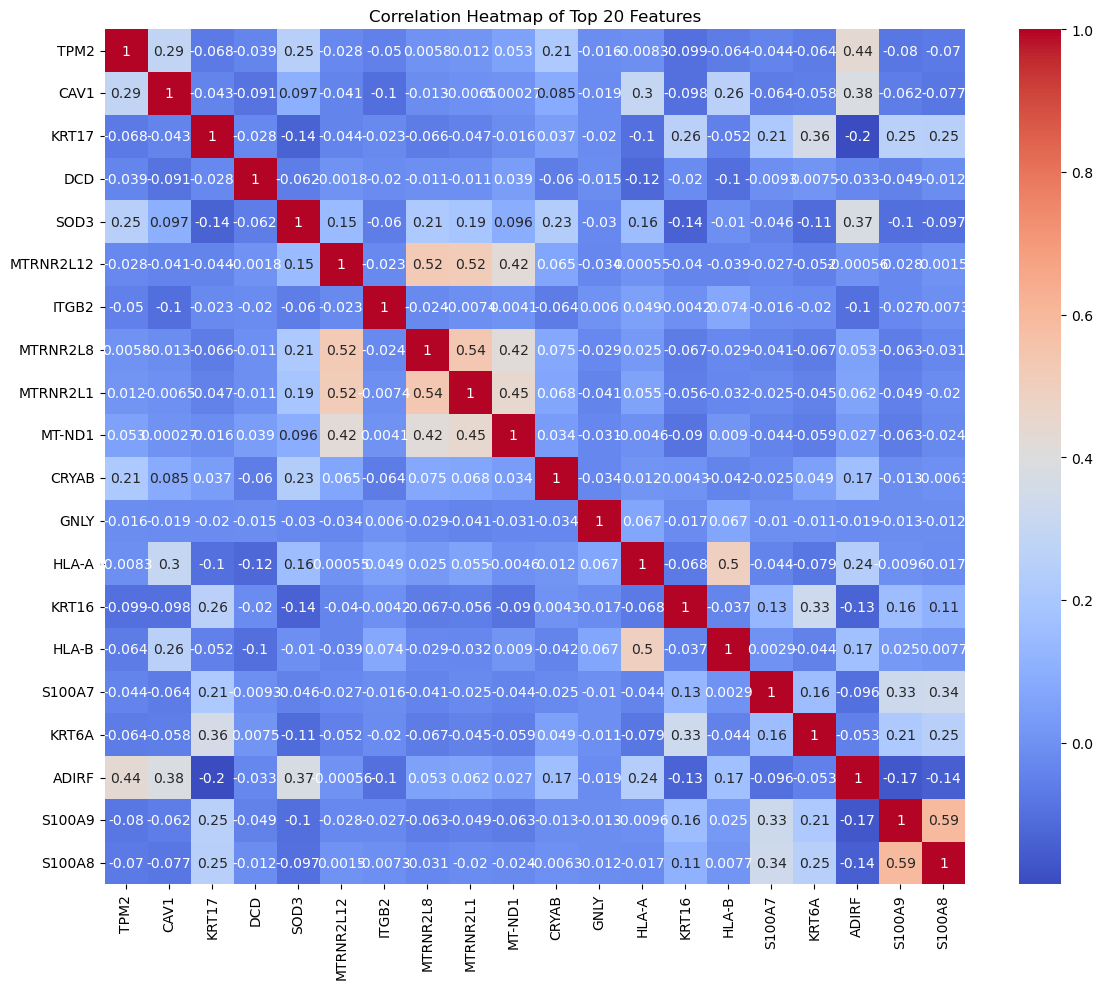

In [ ]:
# Select the top 20 features from the original dataset
top_feature_data = adata[:, top_feature_names].X

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(top_feature_data.T)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=top_feature_names, yticklabels=top_feature_names)
plt.title('Correlation Heatmap of Top 20 Features')
plt.tight_layout()
plt.show()

In [ ]:
# pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
import scanpy as sc
import anndata as ad

# Load the data
data_folder = '/Users/aziz/Untitled Folder/gaydosik_2019_data/gaydosik_2019_filtered'
file_to_load = os.path.join(data_folder, 'hc3.h5ad')
adata = ad.read_h5ad(file_to_load)

# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata, max_value=10)

# Prepare the data for machine learning
X = adata.X
y = adata.obs['predicted_labels'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=1)  # Set n_jobs=1 to disable parallel processing
grid_search.fit(X_train_selected, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred = best_rf_model.predict(X_test_selected)

# Evaluate the model
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Identify top features (potential biomarkers)
feature_importance = best_rf_model.feature_importances_
selected_features = selector.get_support()
feature_names = adata.var_names[selected_features]

top_features = np.argsort(feature_importance)[-20:]
print("\nTop 20 potential biomarkers:")
for idx in reversed(top_features):
    print(f"{feature_names[idx]}: {feature_importance[idx]}")

In [ ]:
for dset in dataset_list:
    sc.pl.umap(dset, color='predicted_labels')

In [ ]:
# pip install --user scikit-misc

In [ ]:
sns.clustermap(scaled_data, z_score=0, cmap = 'RdYlBu_r')

In [ ]:
marker_genes = {
    "LEC (Lymphoendothelial Cells)": ["PECAM1", "FLT1", "TIE1"],
    "MFB (Myofibroblasts)": ["COL1A1", "COL3A1", "SPARC", "VCAM1"],
    "FB (Fibroblasts)": ["COL1A1", "COL3A1", "FAP"],
    "T Cells (TC-1 to TC-5)": ["CD3D", "CD3E", "CD8A", "CD8B", "FOXP3"],
    "NK/NKT Cells": ["KLRF1", "NKG7", "GZMB", "GZMH"],
    "Endothelial Cells (EC)": ["PECAM1", "VWF", "FLT1", "TIE1"],
    "Keratinocytes (KC)": ["KRT14", "KRT5", "SPRR1B", "IVL"],
    "B Cells (BC)": ["MS4A1", "CD79A", "CD79B", "FCRLA"],
    "Dendritic Cells (DC-1 and DC-2)": ["CLEC9A", "FCER1A", "CD1C", "CD1A"],
    "Monocytes (MC-1 to MC-3)": ["CD14", "LYZ", "FCN1", "S100A8", "S100A9"],
    "Macrophages (MΦ)": ["CD68", "CSF1R", "S100A8", "S100A9"],
}

# remove uncommon genes
for key in marker_genes:
    marker_genes[key] = [gene for gene in marker_genes[key] if gene in adata.var_names]

sc.pl.dotplot(adata, marker_genes, groupby="louvain")

In [ ]:
adata.obs["cell_type"] = adata.obs["louvain"].map({
    "0": "Monocytes",
    "1": "Macrophages",
    "2": "T Cells",
    "3": "T Cells",
    "4": "NK/NKT Cells",
    "5": "Myofibroblasts",
    "6": "T Cells",
    "7": "Monocytes",
    "8": "Macrophages",
    "9": "Myofibroblasts",
    "10": "Other",
    "11": "Lymphoendothelial Cells",
    "12": "B Cells",
    "13": "Keratinocytes",
})

# Visualize annotated UMAP
sc.pl.umap(adata, color=["cell_type"], legend_loc="on data", size=50)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="louvain", method="wilcoxon")

sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

markers = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
markers.to_csv("marker_genes.csv")

In [ ]:
import celltypist
import pandas as pd
from anndata import AnnData

# Prepare the input matrix for CellTypist (genes as rows, cells as columns)
expression_matrix = AnnData(
    X=adata.X.T,
    obs=pd.DataFrame(index=adata.var_names),
    var=pd.DataFrame(index=adata.obs_names)
)

model = celltypist.models.download_models('Immune_All_Low.pkl')

In [ ]:
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'custom_rgb_cmap',
    [(0.8, 0.8, 0.8),
     (0.5, 0, 0),
     (1, 0, 0)
    ]
)

adatamarker_genes = [
    "PTPRC", "CDH5", "PROX1", "LAMP3", "MRC1", "CD163",
    "CD68", "CD4", "EDNRA", "KRT5", "FCGR3A", "CD14",
    "CD207", "CD1A", "CD8A", "ACTA2", "DCN", "CD1C",
    "ITGAX", "MS4A1", "MKI67", "KLRC1", "CD3D", "FOXP3"
]

fig, axs = plt.subplots(4, 6, figsize=(10, 10))
for gene in adatamarker_genes:
    if gene in adata.var_names:
        sc.pl.umap(adata, color=gene, title=gene, cmap=custom_cmap, show=False, ax=axs.flat[adatamarker_genes.index(gene)])
        # break
    else:
        print(f"Gene {gene} is not present in the dataset.")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 20))
sc.pl.umap(adata[adata.obs["tissue"] == "skin",:], color=["CellTypist_labels"], legend_loc="on data", size=50, title="Skin", ax=axs[0], show=False, legend_fontsize=5)
axs[0].set_aspect('equal', adjustable='box')
sc.pl.umap(adata[adata.obs["tissue"] == "LN",:], color=["CellTypist_labels"], legend_loc="on data", size=50, title="LN", ax=axs[1], show=False, legend_fontsize=5)
axs[1].set_aspect('equal', adjustable='box')
sc.pl.umap(adata[adata.obs["tissue"] == "PBMC",:], color=["CellTypist_labels"], legend_loc="on data", size=50, title="PBMC", ax=axs[2], show=False, legend_fontsize=5)
axs[2].set_aspect('equal', adjustable='box')
# set ylim to be the same for all subplots
# axs[0].set_ylim(axs[1].get_ylim())
axs[1].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())
plt.tight_layout()
plt.show()

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=20)

In [ ]:
# select just highly variable genes
adata_2 = adata[:, adata.var.highly_variable]

In [ ]:
root_cells = adata_2.obs.index[adata_2.obs["CellTypist_labels"] == "Tcm/Naive helper T cells"]